
![Image](./resources/cropped-SummerWorkshop_Header.png)

<h1 align="center">Encoding </h1> 
<h2 align="center"> Day 1, Morning Session. SWDB 2023 </h2> 

<h3 align="center">Monday, August 21, 2023</h3> 

In [212]:
# We need to import these modules to get started
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

# This patch of code just ensures we get an easy to read font size for the duration of the notebook
import matplotlib
font = {'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>0 Today</h2>

<p>Hubel and Wiesel found orientation and direction selective cells using single wire recordings in the cat primary visual cortex.

To do this, they used a "bespoke" technique - honing in on an individual cell with a high impedance electrode, then manually determining their "best" stimulus to drive that cells behavior. 

In our phasing, we will say that Hubel and Wiesel showed that their exist neurons in V1 that "encode" direction selective information. This was (and still is!) exciting - but it also raises more questions.

Using this idea as a starting place, this Workshop will show how to scale this kind of analysis to survey a population of neurons, and highlight some of the challenges that go with this.

</div>


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2>0.1 Our Questions here </h2>

(1) Do neurons in the mouse visual cortex encode direction?

(2) How reliable are these responses?

(3) What do these responses look like in the neural population? Is this a common phenomena? Is it consistent across cells?

(4) How can we mathematically formalize this analysis?

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>All of out examples today will use the Allen Brain Observatory 2-photon dataset. Before we get started, lets find the dataset and ensure we can access it:
    
<p>The main entry point is the `BrainObservatoryCache` class.  This class is responsible for downloading any requested data or metadata as needed and storing it in well known locations.  For this workshop, all of the data has been preloaded into data assets on CodeOcean - These data are big, and this will save us a lot of bandwidth and time.

    
<p> We begin by importing the `BrainObservatoryCache` class and instantiating it. Here, `manifest_path` is a path to the manifest file. 
</div>

In [213]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = '../data/allen-brain-observatory/visual-coding-2p/manifest.json'
#manifest_file = os.path.join(drive_path,'manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_file)

The 'BrainObservatoryCache object contains all of the functions you need to access brain observatory data. Recall from bootcamp that you can see avalible functions for an object by pressing 'tab' after the period after the object.

In [214]:
boc.

SyntaxError: invalid syntax (<ipython-input-214-9e50d63d0753>, line 1)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## 1 Do neurons in the mouse visual cortex encode direction?

To answer this question, we will use the Allen Brain Observatory dataset(s). These data include a battery of visual stimuli, with accompanying neural recordings from early visual areas. These include static gratings, drifting gratings, locally sparse noise, natural scenes, and some natural movies. The data also includes periods of no stimulus, which allow for "spontaneous" (or at least unstimulated) neural activity. 

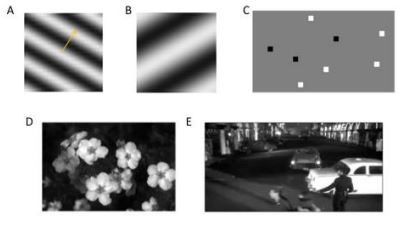




We can use the BrainObservatoryCache to see all the stimuli used:


In [215]:
boc.get_all_stimuli()

['drifting_gratings',
 'locally_sparse_noise',
 'locally_sparse_noise_4deg',
 'locally_sparse_noise_8deg',
 'natural_movie_one',
 'natural_movie_three',
 'natural_movie_two',
 'natural_scenes',
 'spontaneous',
 'static_gratings']

For today's workshop, though, our question is focused on direction selectivity. This means that it makes the most sense to use drifting gratings. Here, gratings are shown across the whole screen, but moved across it in specific directions at specific temporal frequencies. The BrainObservatoryCache can rapidly give us an idea about how much data we might have to answer this question. Hint: its a lot.

In [216]:
sessions_with_drifting_gratings = boc.get_ophys_experiments(stimuli=['drifting_gratings'])
len(sessions_with_drifting_gratings)

456

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## 1.1 Record Neurons; Every recording is biased; its important to know how.

Our goal here is to look at the activity of individual neurons. In this course, you will see data from two primary ways of doing this; in vivo electophysiology (e.g NeuroPixels data) and 2-photon calcium imaging data. 

This is no one right way to record neural activity- each method has its pluses and minuses. Many of you may have in depth understandings of one or both of these methods, but lets think for a moment about how you might select a recording technique to tackle a particular scientific question. 
    
We will discuss these methods briefly now, but the *Data Book* goes into more detail. While this may seem academic, choosing the right data set for the right question will be important to planning your projects!

## 1.1.1 In Vivo Electrophysiology 
In vivo electrophysiology is where you park an electrode next to a cell and record extracellular ion flow from each action potential. 

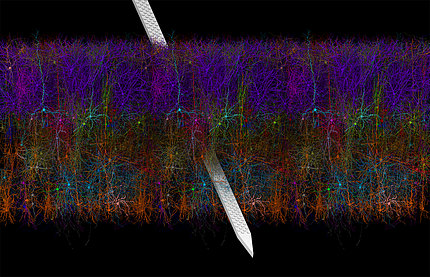








<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h3> This will be held out as part of the answer key. We will lead folks here in discussion. </h3>
 

Advantages: 
- Extremely high time resolution (as fast as you care to sample it). 
- Record from deep structures using longer probes.
- Laminar and structural information
- Record from many structures simultaneously


Disadvantages: 
- You don't know a lot of information about the cells you are recording from.
- Spike sorting - the art of isolating neurons - is an unsolved problem.
- May be biased towards certain kinds of cells (big and/or high firing rate).
- Historically low cell yields per experiment.
- Cannot return to a cell across sessions or experiments.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


## 1.1.2 2-Photon Calcium imaging
Calcium imaging is an optical technique. Neurons are genetically modified to express a GCaMP, a genetically encoded calcium indictor that attaches Green Fluorescent Protein (GFP) to calmodulin, a calcium binding protein. As a result, cells will fluoresce in a  green wavelength when these is a calcium influx into the cell. Since calcium concentration spikes during action potentials, this allows for optical imaging of a given cells activity. 

Here is what this looks like when you stimulate a neuron and simultaneously record its electrophysiological (in this case, via patch clamp) and Ca2+ response (Stosiek et al. 2003, PNAS). Notice that there is a single, slow calcium transient for a much faster burst of spikes.

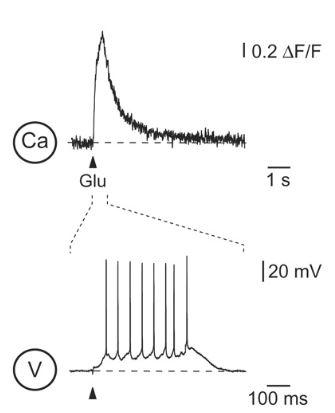    
    
As an historical aside, GFP was discovered here, at Friday Harbor, from the fluorescent jelly fish Aequorea victoria. 

![https://www.thoughtco.com/green-fluorescent-protein-facts-4153062](./resources/AequoreaVictoria.jpg)


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h3> This will be held out as part of the answer key. We will lead folks here in discussion. </h3>
 

Advantages:
- Large populations of neurons
- Cell type information by only expressing Ca2+ indicators in certain cell types.
- Return to specific identified cells across sessions.

Disadvantages
- Activity is recorded indirectly using Ca2+ signal.
- Relatively poor time resolution.
- Limited to one or a few specific fields of view. In these data, that means a specific depth plane, though state-of-the-art techniques can now scan 3d volumes.
- Limited depth without implanting fancy (and destructive) lenses.


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3> This will be held out as part of the answer key. We will lead folks here in discussion. </h3>


## 1.1.3 These pro-con lists are subject to change!
We would be remiss if we didn't point out that the these advantages and disadvantages are rapidly changing, so future experiments might choose different methods for different reasons. 
- Ca2+ indicators are getting faster.
- There are trade offs in temporal and spatial resolution in Ca2+ data aquisition.
- Multi-photon methods are extending the depth-of-field for Ca2+ techniques.
- Better optics are allowing for imaging in deep structures and 3D fields of view.
- Opto-tagging allows for cell type identification in ephys.
- High density probes improve cell yields in ephys.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


## 1.2 Looking at Ca2+ data
For today's question, we want to characterize a population of neurons in visual cortex. Because we want to look at a large population of neurons in a defined spatial region, Ca2+ data makes sense to answer our questions. We are therefore going to dive deeper into data from the Allen Brain Observatory optical dataset. You will learn more about an analogous ephys dataset tomorrow!
    
    

As an aside; if you are wondering about how brain areas in these are recordings are identified, see the *Data Book* description of "Intrinsic Signal Imaging." Technique that optically measures hemodyanmics - effectively, changes in blood oxygenation - and can be used in conjunction with visual stimuli to identify visual areas on the surface of the brain.

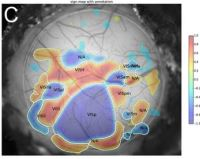



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3>Experiment containers</h3>
 
<p> Now we are ready to access some data!
    
<p>An experiment container describes a set of 3 experiment sessions performed at the same location (targeted area and imaging depth) in the same mouse that targets the same set of cells. Note that this targeting is not perfect- many cells will overlap between sessions, but not all. 

Each experiment container has a unique ID number. For now, lets just choose one to work with.
</div>

In [217]:
expt_container_id = 511507650

In [218]:
# Get the sessions in this experiment container
expt_session_info = boc.get_ophys_experiments(experiment_container_ids=[expt_container_id],)

# Convert to a pandas dataframe for easy access
expt_session_info_df = pd.DataFrame(expt_session_info)
expt_session_info_df

,id,imaging_depth,targeted_structure,cre_line,reporter_line,acquisition_age_days,experiment_container_id,session_type,donor_name,specimen_name,fail_eye_tracking
0,501794235,175,VISp,Cux2-CreERT2,Ai93(TITL-GCaMP6f),107,511507650,three_session_B,222424,Cux2-CreERT2;Camk2a-tTA;Ai93-222424,True
1,500855614,175,VISp,Cux2-CreERT2,Ai93(TITL-GCaMP6f),94,511507650,three_session_C,222424,Cux2-CreERT2;Camk2a-tTA;Ai93-222424,True
2,502115959,175,VISp,Cux2-CreERT2,Ai93(TITL-GCaMP6f),111,511507650,three_session_A,222424,Cux2-CreERT2;Camk2a-tTA;Ai93-222424,True


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3>The Dataset Object</h3>
<p>Each session has a unique `session_id.' These can be used to query a data_set object, which contains information specific to that session.

</div>

In [219]:
# Find experiments that include the "drifting grating" stimulus in our chosen experiment container
expt_session_info = boc.get_ophys_experiments(experiment_container_ids=[expt_container_id],
                                             stimuli=['drifting_gratings'])

# Again, Convert to dataframe for easy access
session_info  = pd.DataFrame(expt_session_info)

# Load the data from our chosen session
session_id = session_info.id.iloc[0]
data_set = boc.get_ophys_experiment_data(ophys_experiment_id=session_id)

The dataset object has a selection of metadata associated with it. 

In [220]:
data_set.get_metadata()

{'sex': 'male',
 'targeted_structure': 'VISp',
 'ophys_experiment_id': 502115959,
 'experiment_container_id': 511507650,
 'excitation_lambda': '910 nanometers',
 'indicator': 'GCaMP6f',
 'fov': '400x400 microns (512 x 512 pixels)',
 'genotype': 'Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/Ai93(TITL-GCaMP6f)',
 'session_start_time': datetime.datetime(2016, 2, 12, 12, 46, 45),
 'session_type': 'three_session_A',
 'specimen_name': 'Cux2-CreERT2;Camk2a-tTA;Ai93-222424',
 'cre_line': 'Cux2-CreERT2/wt',
 'imaging_depth_um': 175,
 'age_days': 112,
 'device': 'Nikon A1R-MP multiphoton microscope',
 'device_name': 'CAM2P.2',
 'pipeline_version': '3.0'}

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## 1.2.1 Cre Lines, Cortical Depth, and other metadata.
    
The dataset metadata include a number of key details for understanding the experiment. 

Lets highlight some key metadata features. These are futher addressed both in todays *Take Home Exercises* and in the *Data Book*
    
<b>Cre Line:</b> Calcium imaging only works if a calcium indicator (here GCaMP) is expressed in cells. Mice are bred express these indicators in particular cell types using the genetic toolkit based around a Cre-Lox system. A genetic line of mice is called a "cre line," with each cre line expressing the GCaMP only in a certain set of genetically targeted cells. Ideally, a cre-line will target a particular cell type (though not all are perfect).

<b>Imaging Depth:</b> Because Ca2+ imaging is an optical technique, recordings must be targeted to a specific focal depth of the microscope, corresponding to how deep in the tissue the images were collected. 

https://help.brain-map.org/display/observatory/Allen+Brain+Observatory+-+Overview#:~:text=Intrinsic%20signal%20imaging%20%28ISI%29%20measures%20hemodynamic%20response%20to,field%20to%20corresponding%20locations%20within%20responsive%20cortical%20areas.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## 1.2.2 DF/F Traces

Calcium signalling is a measurment of fluorecesnse, in this case the intensity of fluorecesnse at the soma of the cell. Because the amount of calcium in a cell is never 0 (and because all cells have some native fluorecesnse without the indictator active), we cannot simply measure raw fluorecense signal. Instead, what we care about is change in fluorecesse to some baseline value, that is, $\Delta f/f$ (typically writen df/f or simply dff). The *Data Book* contains more information on how the Allen Ca2+ data were processed.
    


In [221]:
# Get the df/f traces for every cell from this session. 
# "get_dff_traces" returns a tuple with two values, the timestamps and the dff_traces.
timestamps,dff_traces = data_set.get_dff_traces()

# Take a look at the size and shape
num_cells = dff_traces.shape[0]
print("Number of cells: " + str(num_cells))
print("Number of frames: " + str(len(timestamps)))



Number of cells: 205
Number of frames: 115470


Text(0.5, 0, 'df/f')

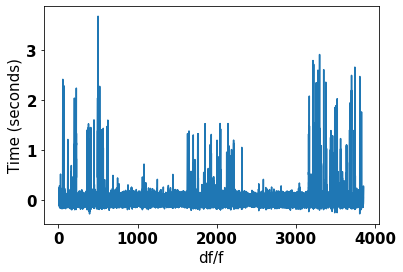

In [222]:
# Grab a cell to look at
cell_idx = 7

# And plot its dff trace
fig,ax = plt.subplots()
ax.plot(timestamps,dff_traces[cell_idx,:])
ax.set_ylabel('Time (seconds)')
ax.set_xlabel('df/f')


Stimulus information is contained in tables as part of the dataset object

In [223]:
stim_table = data_set.get_stimulus_table("drifting_gratings")
stim_table.head()

,temporal_frequency,orientation,blank_sweep,start,end
0,2.0,45.0,0.0,746,806
1,15.0,90.0,0.0,837,896
2,4.0,90.0,0.0,927,987
3,2.0,45.0,0.0,1017,1077
4,4.0,90.0,0.0,1108,1167


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h3>Now we have data to work with!</h3>

This means we can start actually plotting some of stimulus responses for specific stimuli.

Lets start by plotting df/f for a single trial. For comparison, we will grab a little bit of time (1 second) on either side of the two second trial.

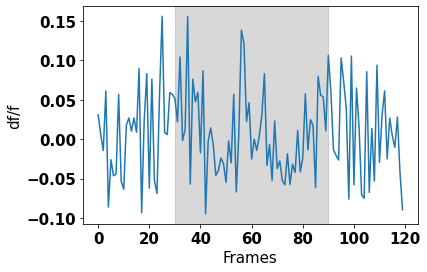

In [254]:

fig,ax = plt.subplots()
# Plot one trial worth of df/f
ax.plot(this_dff[int(stim_table.start[0])-30:int(stim_table.end[0])+30])
ax.axvspan(30,90, color='gray', alpha=0.3) #this shades the period when the stimulus is being presented
ax.set_ylabel("df/f")
ax.set_xlabel("Frames");


Now lets grab a (more interesting) trial.

Text(0.5, 0, 'Frames')

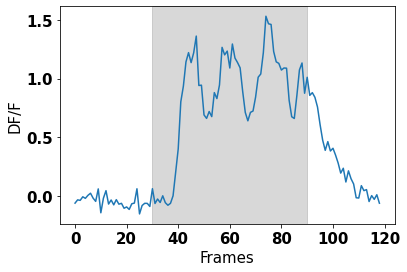

In [225]:
# Define a time range for the plot
fig,ax = plt.subplots()
# Plot the df/f trace
ax.plot(this_dff[stim_table.start[115]-30:stim_table.end[115]+30])
ax.axvspan(30,90, color='gray', alpha=0.3) #this shades the period when the stimulus is being presented
ax.set_ylabel("DF/F")
ax.set_xlabel("Frames")

## TRIAL 438 On saskia's cell


We can filter the stim table to look for all the trails of this type

In [226]:
stim_table.iloc[115]

temporal_frequency        2.0
orientation             315.0
blank_sweep               0.0
start                 11132.0
end                   11191.0
Name: 115, dtype: float64

In [227]:
this_stim_table = stim_table[(stim_table.temporal_frequency==2) & (stim_table.orientation==315)]
this_stim_table

,temporal_frequency,orientation,blank_sweep,start,end
115,2.0,315.0,0.0,11132,11191
162,2.0,315.0,0.0,15375,15435
170,2.0,315.0,0.0,16098,16157
196,2.0,315.0,0.0,18445,18505
201,2.0,315.0,0.0,48696,48756
246,2.0,315.0,0.0,52759,52819
340,2.0,315.0,0.0,61248,61307
371,2.0,315.0,0.0,64047,64106
376,2.0,315.0,0.0,64498,64558
418,2.0,315.0,0.0,96283,96342


In [228]:
len(this_stim_table)

15

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #DFF0D8; ">
    
    <h3> Task 2 </h3>
    
     Plot the sorted events for the first and second halves of the session

In [229]:
fig,ax = plt.subplots()
ax.axvspan(30,90, color='gray', alpha=0.3) 
# THIS IS A SUPER HANDY WAY TO INTERATE THROUGH A TABLE!!!
for ii,row in this_stim_table.iterrows():
    # Your Code Here!


SyntaxError: unexpected EOF while parsing (<ipython-input-229-dc7dd9c10dc2>, line 5)

In [230]:
# hint:
row

temporal_frequency         2.0
orientation              315.0
blank_sweep                0.0
start                 112175.0
end                   112234.0
Name: 594, dtype: float64

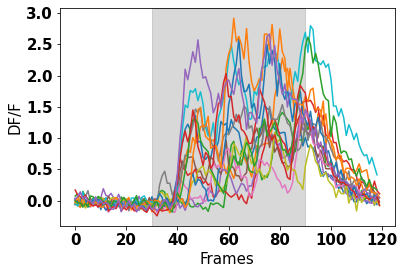

In [231]:
# Solution
fig,ax = plt.subplots()
ax.axvspan(30,90, color='gray', alpha=0.3) 

# Iterrows is a handy way to iterate through a table.
# Here, ii will be the index in the table, 
# and "row" will be a dataframe containing only the row the iterator is currently on. 
for ii,row in this_stim_table.iterrows():
    # Exersize: Plot 
    ax.plot(dff_traces[cell_idx,int(row.start)-30:int(row.end)+30])
    ax.set_ylabel("DF/F")
    ax.set_xlabel("Frames")

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## 1.2.1.3: Event detection
Calcium signal is a continuous variable. We know, however, that most large influxes of calcium are associated with one or more spikes taking place in the neuron in question. These spikes are associated with a large influx of calcium into the cell, followed by a slow decay in the fluorescence signal. Importantly, this also presents a potential problem with calcium imaging; signals in the past contaminate signals in the future.

One solution to this problem is to do deconvolution of the calcium events from the time course of the df/f trace. Deconvolution is the process of separating two signals (in this case, the cell's response from the GCaMP and imaging dynamics). Deconvolution is a computationally hard and expensive problem. One such algorithm has already been run for us on these data. This algorithm makes some reasonable assumptions about the dynamics of df/f responses relative to calcium traces, and uses these to extract event times and event amplitudes from the df/f trace. A very excellent description of this method is here https://jewellsean.github.io/fast-spike-deconvolution/index.html. We will work with its outputs for the duration of this course.

A quick word on nomenclature: We don't actually know what caused a spike in calcium. It was most likely a single action potential or a burst of spikes in quick succession, but we don't know which and we did not explicitly observe either. We therefore refer to calcium "events" as a source-agnostic way to describe this calcium activity.

Events for each session have been pre computed

In [232]:
events = boc.get_ophys_experiment_events(ophys_experiment_id=session_id)

Each event is discrete, and has both a timestamp and an amplitude. Lets look at how these relate to the same df/f trace from before.

We know the frame rate for our data is about 30 Hz, and we know that stimuli were show for 2 seconds. We can use this information to plot data centered around the trial start, with a buffer on each side.

Text(0, 0.5, 'Event Magnitude')

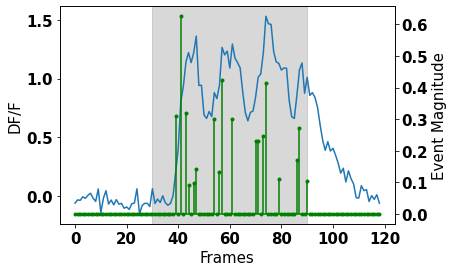

In [233]:
fig,ax = plt.subplots()
ax.axvspan(30,90, color='gray', alpha=0.3) 

# Plot the DF/F trace
ax.plot(dff_traces[cell_idx,stim_table.start[115]-30:stim_table.end[115]+30])
ax.set_ylabel("DF/F")
ax.set_xlabel("Frames")

# Define a new axis that shares the X axis, but can have a different Y
ax_ = ax.twinx()

# Plot the events 
trial_events = events[cell_idx,stim_table.start[115]-30:stim_table.end[115]+30]
ax_.stem(np.arange(0,len(trial_events)),# Stem requires a x axis input: just use 0:1:N
                 trial_events, 'g', markerfmt='g.', basefmt='g-')
ax_.set_ylabel("Event Magnitude")

Like df/f, event magnitudes are dimensionless units describing how much that event changed the Ca2+ signal. 

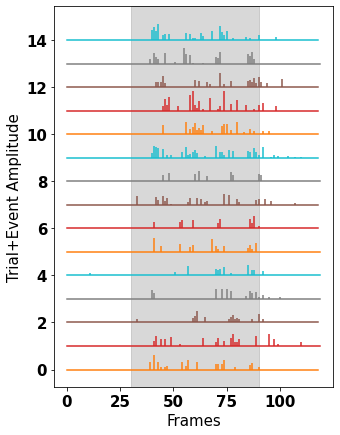

In [234]:
fig,ax = plt.subplots(figsize = (5,7))
ax.axvspan(30,90, color='gray', alpha=0.3) #this shades the period when the stimulus is being presented

# Since iterrows uses the dataframe index as an iterator, we need our own trial counter
trlidx = 0

for ii,row in this_stim_table.iterrows():
    trial_events = events[cell_idx,int(row.start)-30:int(row.end)+30]
    
    # The stem plot returns multiple plotting objects, so that we can interact with them seperatly.
    markerline, stemlines, baseline = ax.stem(np.arange(0,len(trial_events)),
            trial_events+trlidx,
            bottom = trlidx,markerfmt=' ',basefmt='-')
    
    # This line just makes sure the line and stems are the same color 
    plt.setp(stemlines, 'color', plt.getp(baseline,'color'))

    trlidx+=1 # Update trial counter
    
    ax.set_ylabel("Trial+Event Amplitude")
    ax.set_xlabel("Frames")

A quick note- here, we are approximating time by assuming a 30 Hz sampling rate. This isn't strictly true; if you look at the timestamps for a session, they do not always have consistent intervals. What is more, if we round stimulus presentation to the nearest timestamp we do not always get exactly the same trial length (some are 60 frames, some are 59). So, while this approximation is fine for what we are doing here today, it might not always be a safe thing to do! 



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## 1.3 Do neurons in the mouse visual cortex encode direction?


For each trial, lets get the orientation, temporal frequency, and response for this cell.

In [235]:
# Create arrays for orientation, temporal frequency, and response
# Initially these will just be zeros, but we will fill the in with a loop
orientation = np.zeros((len(stim_table)))
temp_freq = np.zeros((len(stim_table)))

# We now have two response variables, one for dF/F and one for events. Since we
# are mostly going to be analysing events, we won't put a qualifier on the name
# of this variable.
dff_response = np.zeros((len(stim_table),60))
response = np.zeros((len(stim_table),60))

# Loop through each stimulus presentation, store its parameters
for ii in range(len(stim_table)):
    orientation[ii] = stim_table.orientation[ii]
    temp_freq[ii] = stim_table.temporal_frequency[ii]
    dff_response[ii,:] = this_dff[stim_table.start[ii]:stim_table.start[ii]+60]
    response[ii,:] = events[cell_idx,stim_table.start[ii]:stim_table.start[ii]+60]

In [236]:
# The response matrix here is a 2D array, with each row representing the
# response on a single trials.
response.shape

(628, 60)

For now, we can subsample only to the temporal frequency we were looking at before.

In [237]:
orientation = orientation[temp_freq==2]
dff_response = dff_response[temp_freq==2,:]
response = response[temp_freq==2,:]

The 'unique' command is useful here. Not only will it tell us the list of unique stimuli shown, but it will provide an (optional) "inverse" variable that can be used to reconstruct the original array. Lets take a look:

In [238]:
orientations,ix = np.unique(orientation,return_inverse=True)
print(orientations)


[  0.  45.  90. 135. 180. 225. 270. 315.]


In [239]:
# The variable 'ix' maps the values in 'orientation' to the values in
# 'orientations'
print(ix[1:10])
print(orientation[1:10])
print(orientations[ix[1:10]])

[1 5 6 2 4 6 6 0 0]
[ 45. 225. 270.  90. 180. 270. 270.   0.   0.]
[ 45. 225. 270.  90. 180. 270. 270.   0.   0.]


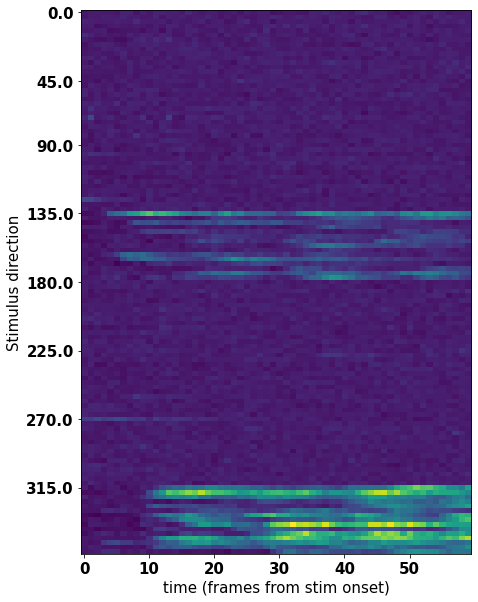

In [268]:
# sorting on the inverse index will put the trials in order of orientation
sort_order = np.argsort(ix)

fig,ax = plt.subplots(figsize=(7,10))
# Plot the dff matrix
ax.imshow(dff_response[sort_order,:],aspect='auto')
ax.set_ylabel('Stimulus direction')
ax.set_xlabel('time (frames from stim onset)')

# The unique command can also return the first time a unique variable occures.
# Here, we will use that denote the blocks of stimuli in our sorted plot
_,first_instance = np.unique(np.sort(ix),return_index=True)
ax.set_yticks(first_instance)
ax.set_yticklabels(orientations);

In [263]:
_,first_instance = np.unique(np.sort(ix),return_index=True)


Before we get too far, we are going to divide the data in half. Don't worry too much about this right now - eventually it will allow us to quantify some of the variability in our data, but we will talk about this at length later.

In [241]:

divider = len(orientation)//2
orientation_a = orientation[:divider]
orientation_b = orientation[divider:]
temp_freq_a = temp_freq[:divider]
temp_freq_b = temp_freq[divider:]
response_a = response[:divider,:]
response_b = response[divider:,:]
ix_a = ix[:divider]
ix_b = ix[divider:]


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #DFF0D8; ">
    
    <h3> Task 2 </h3>
    
     Plot the sorted events for the first and second halves of the session

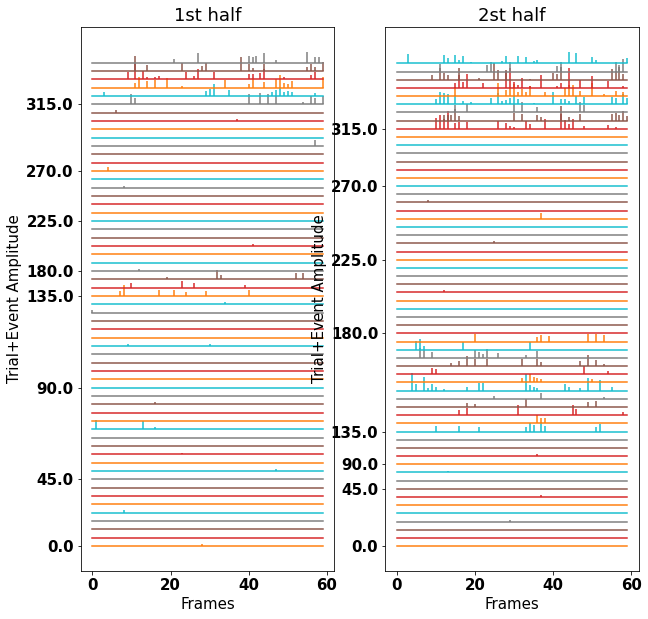

In [272]:
fig,ax = plt.subplots(ncols=2,figsize = (10,10))

# Since iterrows uses the dataframe index as an iterator, we need our own trial counter
trlidx = 0

sort_order = np.argsort(ix_a)
for ii,ss in enumerate(sort_order):
    markerline, stemlines, baseline = ax[0].stem(np.arange(0,60),
            3*response_a[ss,:]+trlidx,
            bottom = trlidx,markerfmt=' ',basefmt='-')
    plt.setp(stemlines, 'color', plt.getp(baseline,'color')) # This line just makes sure the line and stems are the same color 
    trlidx+=1 # Update trial counter
    
ax[0].set_ylabel("Trial+Event Amplitude")
ax[0].set_xlabel("Frames")
ax[0].set_title("1st half")

# Denote the blocks of stimuli in our sorted plot
_,first_instance = np.unique(np.sort(ix_a),return_index=True)
ax[0].set_yticks(first_instance)
ax[0].set_yticklabels(orientations);

# Add your code for the second half of the session here

# SOLITON:
trlidx = 0
sort_order = np.argsort(ix_b)

for ii,ss in enumerate(sort_order):
    markerline, stemlines, baseline = ax[1].stem(np.arange(0,60),
            3*response_b[ss,:]+trlidx,
            bottom = trlidx,markerfmt=' ',basefmt='-')
    plt.setp(stemlines, 'color', plt.getp(baseline,'color')) # This line just makes sure the line and stems are the same color 

    
    trlidx+=1 # Update trial counter
ax[1].set_ylabel("Trial+Event Amplitude")
ax[1].set_xlabel("Frames")
ax[1].set_title("2st half")
_,first_instance = np.unique(np.sort(ix_b),return_index=True)
ax[1].set_yticks(first_instance)
ax[1].set_yticklabels(orientations);

It is going to be easier to look at each response as a single number, rather than a 2-second time series. 
For this, if we were working with df/f traces, one option would be to take the average of the full 2 second window. Because all our time windows here are the same length, this will be proportional to the area under each response curve.

Even though we are looking at events, we can still average or sum the event total over the same window. Our response magnitude will now be measured as average (giving a event magnitude rate) or a sum (giving a total/cumulative event magnitude).

In [243]:
mean_response_a = response_a.mean(axis =1)
mean_response_b = response_b.mean(axis =1)

In [244]:
print(mean_response_a.shape)
print(mean_response_b.shape)

(59,)
(60,)


Text(0, 0.5, 'Trial Event Rate')

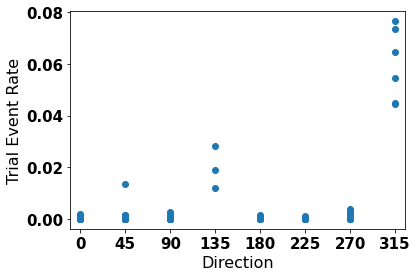

In [245]:
fig,ax = plt.subplots()
ax.plot(orientation_a, mean_response_a, 'o')
ax.set_xticks(orientations)
ax.set_xlim(-10,325)
ax.set_xlabel("Direction", fontsize=16)
ax.set_ylabel("Trial Event Rate", fontsize=16)

Text(0, 0.5, 'Trial Event Rate')

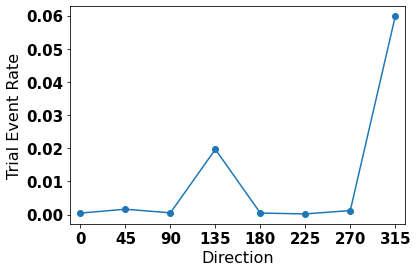

In [246]:
tuning_a = np.zeros(orientations.shape)
for ii in range(orientations.shape[0]):
    tuning_a[ii] = mean_response_a[ix_a==ii].mean()
    
fig,ax = plt.subplots()
ax.plot(orientations,tuning_a, 'o-')
ax.set_xticks(orientations)
ax.set_xlim(-10,325)
ax.set_xlabel("Direction", fontsize=16)
ax.set_ylabel("Trial Event Rate", fontsize=16)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## 1.4 Descriptive statistics
    
What we have done thus far is describe the response of our cell in terms of its average response to each grating direction. 
    
Its worth noting that the nice folks who put together data dataset have precomputed a number of nice summery statistics that can be used to perform basic characterizations of this type.
    
## To Do: 
    
Cut down discriptive stats part. Define DSI, have function to compute, move looking at the population to the homework. Do it for whole session, and with cross validation? Introduce bootstrapping in Homework?
    
("No one should mess with the cell table if they can avoid it...")


In [247]:
# Load the cell table for all cells.
cell_table = pd.DataFrame(boc.get_cell_specimens())
cell_table.keys()

Index(['p_run_mod_sg', 'tlr1_id', 'image_sel_ns', 'tlr1_name', 'g_dsi_dg',
       'p_ns', 'specimen_id', 'p_dg', 'time_to_peak_sg', 'pref_dir_dg',
       'dsi_dg', 'rf_overlap_index_lsn', 'rf_distance_lsn', 'tld1_name',
       'osi_dg', 'pref_image_ns', 'experiment_container_id', 'peak_dff_sg',
       'osi_sg', 'rf_center_on_y_lsn', 'time_to_peak_ns', 'rf_chi2_lsn',
       'failed_experiment_container', 'reliability_ns', 'tld1_id',
       'reliability_sg', 'imaging_depth', 'run_mod_ns', 'rf_center_on_x_lsn',
       'area', 'peak_dff_dg', 'p_sg', 'rf_area_on_lsn', 'tld2_name',
       'pref_ori_sg', 'rf_area_off_lsn', 'p_run_mod_ns', 'pref_phase_sg',
       'rf_center_off_y_lsn', 'pref_tf_dg', 'tfdi_dg', 'cell_specimen_id',
       'reliability_dg', 'tld2_id', 'run_mod_dg', 'p_run_mod_dg',
       'reliability_nm1_a', 'reliability_nm1_c', 'reliability_nm1_b',
       'rf_center_off_x_lsn', 'peak_dff_ns', 'donor_full_genotype', 'all_stim',
       'run_mod_sg', 'pref_sf_sg', 'sfdi_sg', 'g_osi

Some things we already computed are already in this table- we can query to confirm we this right.

In [248]:
this_cell_id = data_set.get_cell_specimen_ids()[cell_idx]
cell_table[cell_table.cell_specimen_id==this_cell_id].pref_dir_dg

576    315.0
Name: pref_dir_dg, dtype: float64

We can also query this table for various metrics, starting with the "orientation selectivity index" - a value between 0 and 2 that specifies how selective a cell is.

Note that these are computed over all temporal frequencies - we will use them for now, but you might want to recompute depending on your specific question. For now though, lets look at how this stacks up next to the other simultaneously recorded cells.

In [249]:
this_dsi = cell_table[cell_table.cell_specimen_id==this_cell_id].g_dsi_dg.values[0]
print(this_dsi)

0.410152348149383


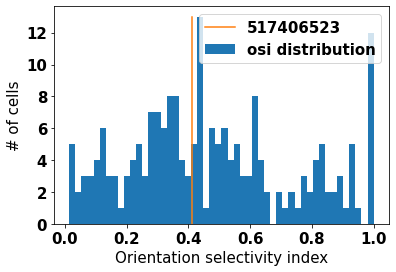

In [250]:
fig,ax = plt.subplots()
hh = ax.hist(cell_table[cell_table.experiment_container_id==expt_container_id].g_dsi_dg,50,label = 'osi distribution')
ax.plot([this_dsi,this_dsi],[0, np.max(hh[0])],label = str(this_cell_id))
ax.set_xlabel('Orientation selectivity index')
ax.set_ylabel('# of cells')
ax.legend()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## 2 How reliable are these responses?


We can use our tuning curve as a simple model of the receptive field if we use it like a look up table: for each stimulus direction, we know what the mean response of the cell will be. Using the index established above, we can query the tuning curve for the expected response amplitude of the cell.

In [251]:
prediction_aa = tuning_a[ix_a]

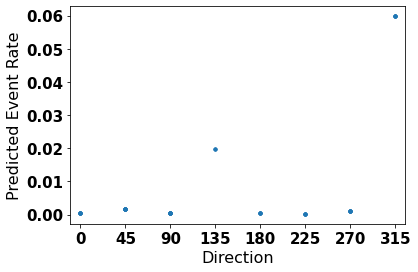

In [252]:
fig,ax = plt.subplots()
ax.plot(orientation_a,prediction_aa, '.')
ax.set_xticks(orientations)
ax.set_xlim(-10,325)
ax.set_xlabel("Direction", fontsize=16)
ax.set_ylabel("Predicted Event Rate", fontsize=16);

# Notice that even though there are multiple trials at each direction, 
# they all get the same prediction.

One method for quantifying how well a prediction does is to simply compute the prediction error, that is, how far off the prediction was from the observed value. These are also called the model residuals.

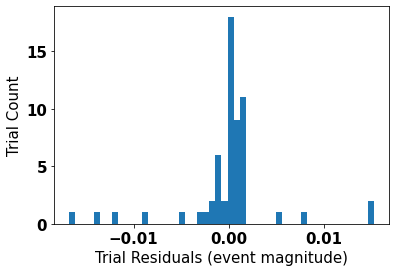

In [253]:
residual = prediction_aa- mean_response_a

fig,ax = plt.subplots()
ax.hist(residual,bins=50);
ax.set_xlabel('Trial Residuals (event magnitude)')
ax.set_ylabel('Trial Count');

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
By itself, though, simply computing the residual error on every point can be difficult to interpret.
    
One popular metric for assessing this kind of mode is the "coefficient of determination," or $R^2$. $R^2$ asks compares the sum of squared residuals in our model, $SS_{residuals}$, to the total sum of squares $SS_{total}$, effectively asking "How much of the variance in our data is explained by our model?." $R^2$ is defined:
    
 $$R^2 = 1-\frac{SS_{residuals}}{SS_{total}}$$

Because a perfect model will have zero residuals and worthless model will explain no variance, subtracting this ratio from 1 lends interpretability. A perfect model will have zero residuals, and therefore $R^2=1$. If no variance is explained $R^2$ will equal 0. Values in between can be interpreted as "fraction of variance explained."

Time to try it!

In [47]:
residuals_aa  =  np.mean((residual)**2)
residuals_aa

2.2239849412163577e-05

In [48]:
total_variance_aa = np.mean((mean_response_a-np.mean(mean_response_a))**2)
total_variance_aa

0.0003461181065771978

In [49]:
r2_aa = 1-residuals_aa/total_variance_aa
r2_aa

0.9357449119547774

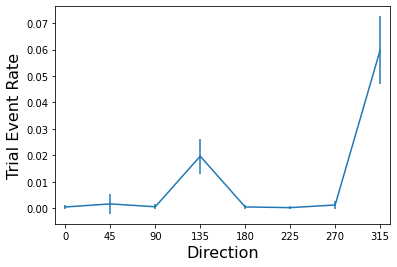

In [50]:
stdev_a = np.zeros(orientations.shape)
for ii in range(orientations.shape[0]):
    stdev_a[ii] = mean_response_a[ix_a==ii].std()

fig,ax = plt.subplots()
ax.errorbar(orientations,tuning_a,stdev_a)
ax.set_xticks(orientations)
ax.set_xlim(-10,325)
ax.set_xlabel("Direction", fontsize=16)
ax.set_ylabel("Trial Event Rate", fontsize=16);

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
  
## 2.1 Splitting and Validation
    
You will probably have noticed that we split our data in half before we fit our initial model.
    
This is because, up to this point, we have been building our model on the same data we are using to quantify its predictive power. What we really want to know, though, is how well this model can predict data that it has never seen before. Splitting the data early on gives us an additional set of trials with which to test these model predictions.
    

Look at the data from both parts of the split.

Text(0, 0.5, 'Trial Event Rate')

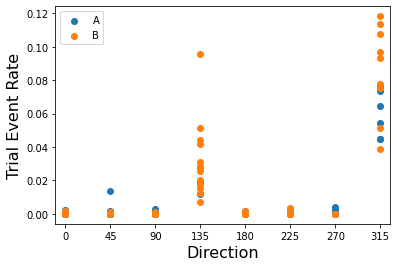

In [51]:
fig,ax = plt.subplots()
ax.scatter(orientation_a, mean_response_a,label = 'A')
ax.scatter(orientation_b, mean_response_b,label = 'B')

ax.set_xticks(orientations)
ax.legend()
ax.set_xlim(-10,325)
ax.set_xlabel("Direction", fontsize=16)
ax.set_ylabel("Trial Event Rate", fontsize=16)

We can make predictions about out 'testing' data using the same indexing technique.

In [52]:
prediction_ab = tuning_a[ix_b]

Computing $R^2$ is something that we are likely going to want to do many times. It is therefore helpful to write a function that tackles what we did earlier.

In [53]:
def compute_coefficient_of_determination(mean_response,prediction):
    """
    Compute the coefficient of determination (R^2) for a set of data
    
    Parameters
    ----------
    mean_response : np.array
        The mean response for each stimulus
    prediction : np.array
        The predicted response for each stimulus
    
    Returns
    -------
    r2 : float
        The coefficient of determination
    """

    residual = mean_response-prediction
    sum_of_squared_residual  =  np.mean((residual)**2)
    total = np.mean(mean_response)-mean_response
    sum_of_squared_total  =  np.mean((total)**2)
    r2 = 1-sum_of_squared_residual/sum_of_squared_total
    return r2

In [54]:
r2_ab = compute_coefficient_of_determination(mean_response_b,prediction_ab)
r2_ab

0.7001353662185335

In [55]:
r2_aa

0.9357449119547774

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
  
So- Our model did very well (87% of variance explained) in predicting the data it was trained on, but less well (only 57% variance explained) on held out data. To get a sense of what these numbers mean, lets try looking at another cell.

Here, we repeat what we did above, but this time use an additional for-loop to compute the response for every cell on every trial. This will allow us to query a table of cell responses, and save us from having to re-do this math every time we want to look at addition cells.

In [56]:
#orientation = np.zeros((len(stim_table)))
#temp_freq = np.zeros((len(stim_table)))
response = np.zeros((len(stim_table),60))
mean_response_all = np.zeros((len(stim_table),num_cells))
for ii in range(len(stim_table)):
    #orientation[ii] = stim_table.orientation[ii]
    #temp_freq[ii] = stim_table.temporal_frequency[ii]
    for cc in range(num_cells):
        this_response =  events[cc,stim_table.start[ii]:stim_table.start[ii]+60]
        mean_response_all[ii,cc] = this_response.mean()

mean_response_all = mean_response_all[temp_freq==2,:]
        
divider= len(mean_response_all)//2      
mean_response_all_a = mean_response_all[:divider,:]
mean_response_all_b = mean_response_all[divider:,:]


Similarly, we probably want a function that does the math on computing tuning curves:

In [57]:
def compute_tuning_curve(mean_response,orientation,orientations):
    """
    Compute the tuning curve for a set of reponses and orientations
    
    Parameters
    ----------
    mean_response : np.array
        The mean response for each stimulus
    orientation : np.array
        Orientation of each stimulus
    orientations: np.array
        All orientations to compute tuning over
        Useful when a subset of orientations are needed.
    
    Returns
    -------
    tuning : np.array
        mean response at each orientation
    stdev: np.array 
        Standard deviation of responses at each orientation
    """
    tuning = np.zeros(orientations.shape)
    stdev = np.zeros(orientations.shape)
    for ii,ori in enumerate(orientations):
        tuning[ii] = mean_response[orientation==ori].mean()
        stdev[ii] = mean_response[orientation==ori].std()
    return tuning,stdev
    

Lets grab a different cell

In [273]:
another_index =6

In [274]:

this_tuning_a,this_stdev_a = compute_tuning_curve(mean_response_all_a[:,another_index],orientation_a,orientations) 

fig,ax = plt.subplots()
ax.plot(orientations,this_tuning_a, 'o-')

ax.set_xticks(orientations)
ax.set_xlim(-10,325)
ax.set_xlabel("Direction", fontsize=16)
ax.set_ylabel("Trial Event Rate", fontsize=16)

NameError: name 'compute_tuning_curve' is not defined

In [59]:
this_cell_id = data_set.get_cell_specimen_ids()[another_index]
this_osi = cell_table[cell_table.cell_specimen_id==this_cell_id].dsi_dg
print(this_osi) # Not that different from our last cell.

876    0.476428
Name: dsi_dg, dtype: float64


It looks like this cell has a sharp tuning peak at 180 degrees. 

How much variance does our model explain?

In [60]:
compute_coefficient_of_determination(mean_response_all_a[:,another_index],this_tuning_a[ix_a])

0.16463724593488072

Text(0, 0.5, 'Trial Event Rate')

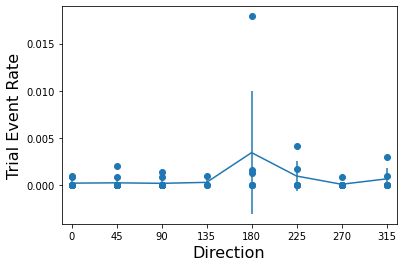

In [61]:
fig,ax = plt.subplots()

ax.errorbar(orientations,this_tuning_a,this_stdev_a,)
ax.scatter(orientation_a,mean_response_all_a[:,another_index])

ax.set_xticks(orientations)
ax.set_xlim(-10,325)
ax.set_xlabel("Direction", fontsize=16)
ax.set_ylabel("Trial Event Rate", fontsize=16)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Compare the figure here for to the one we made for the last cell. Before, the amplitude of the cells response to its "preferred" stimulus was now always the same, but it was reliably larger than for it's non-preferred stimuli. We quantified this by showing that splitting our data and showing a model fit on the first half of the data did reasonably well on the second half. Here, though, really only one trial is driving the peak in the tuning curve.
    
What happens if we compute $R^2$ on our held out data?
    

In [62]:
compute_coefficient_of_determination(mean_response_all_b[:,another_index],this_tuning_a[ix_b])


-3.0419608374750418

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
Here, a negative $R^2$ value means that not only did we explain NON of variance in the second half of our data, but our model did worse than if we had just guessed with the mean of these data. This is pretty clearly a sign that we have built a bad model.
    
To visualize this, we should look at the responses for each stimulus.

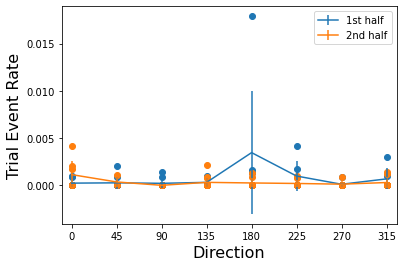

In [63]:
fig,ax = plt.subplots()
ax.errorbar(orientations,this_tuning_a,this_stdev_a,label = '1st half')
ax.scatter(orientation_a,mean_response_all_a[:,another_index])

this_tuning_b,this_stdev_b = compute_tuning_curve(mean_response_all_b[:,another_index],orientation_b,orientations) 

ax.errorbar(orientations,this_tuning_b,this_stdev_b,label = '2nd half')
ax.scatter(orientation_b,mean_response_all_b[:,another_index])
ax.set_xticks(orientations)
ax.set_xlim(-10,325)
ax.set_xlabel("Direction", fontsize=16)
ax.set_ylabel("Trial Event Rate", fontsize=16)
ax.legend()


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

The moral of this story is that a 'peak' in a tuning curve DOES NOT necessarily mean the cell is reliably tuned! 
    
What is more, simply plotting or quantifying tuning curves would have failed to diagnose this problem, since our second cell appeared to have a large peak in its response curve.
    
We call this technique for assessing models "data splitting". The segment of the data we built our model with is called the "training set," and the set of data we tested with is called the "testing set." 
    
Next, we will use this technique to scale up our analysis and look at every cell in this session.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## 3 What do responses look like an a neural population?

In [64]:

many_r2_train = np.zeros(len(dff_traces))
many_r2_test = np.zeros(num_cells)

tuning_train = np.zeros((num_cells,orientations.shape[0]))
stdev_train = np.zeros((num_cells,orientations.shape[0]))

tuning_test = np.zeros((num_cells,orientations.shape[0]))
stdev_test = np.zeros((num_cells,orientations.shape[0]))

for cc in range(num_cells):

    tuning_train[cc,:],stdev_train[cc,:] = compute_tuning_curve(mean_response_all_a[:,cc],orientation_a,orientations)
    tuning_test[cc,:],stdev_test[cc,:] = compute_tuning_curve(mean_response_all_b[:,cc],orientation_b,orientations)

    this_prediction_train = tuning_train[cc,ix_a]
    this_prediction_test = tuning_train[cc,ix_b]

    many_r2_train[cc] = compute_coefficient_of_determination(mean_response_all_a[:,cc],this_prediction_train)
    many_r2_test[cc] = compute_coefficient_of_determination(mean_response_all_b[:,cc],this_prediction_test)
    

<ipython-input-53-74aef1d80740>:22: RuntimeWarning: divide by zero encountered in scalar divide
  r2 = 1-sum_of_squared_residual/sum_of_squared_total
<ipython-input-53-74aef1d80740>:22: RuntimeWarning: invalid value encountered in scalar divide
  r2 = 1-sum_of_squared_residual/sum_of_squared_total


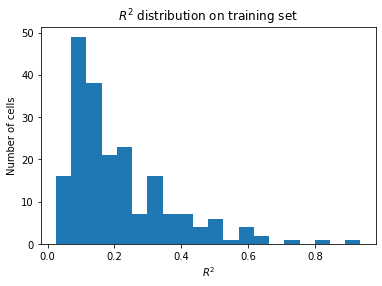

In [65]:
fig,ax = plt.subplots()
ax.hist(many_r2_train,bins=20);
ax.set_xlabel('$R^2$')
ax.set_ylabel('Number of cells')
ax.set_title('$R^2$ distribution on training set');


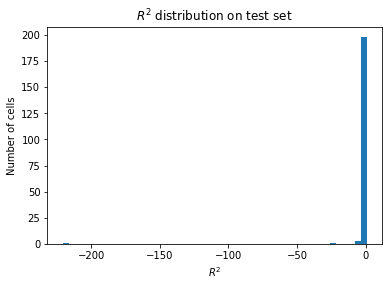

In [66]:

fig,ax = plt.subplots()

# r2 may not always be defined on the test set- this can happen when no events
# occurred, and we our math tells us we have "infinate" error. 
# We'll set these to nan - a maker of missing data - so they don't mess up our
# analysis.
many_r2_test[np.isinf(many_r2_test)]=np.nan

ax.hist(many_r2_test,bins=50);
ax.set_xlabel('$R^2$')
ax.set_ylabel('Number of cells')
ax.set_title('$R^2$ distribution on test set');
# Yikes!

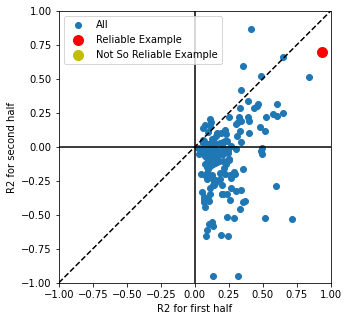

In [67]:
fig,ax=plt.subplots(figsize=(5,5))
ax.scatter(many_r2_train,many_r2_test,label = 'All')
ax.scatter(r2_aa,r2_ab,c='r',s=100,label = 'Reliable Example')
ax.scatter(many_r2_train[another_index],many_r2_test[another_index],c='y',s=100,label = 'Not So Reliable Example')

ax.plot([-1,1],[-1,1],'k--')
ax.plot([-1,1],[0,0],'k')
ax.plot([0,0],[-1,1],'k')
ax.set_xlabel('R2 for first half')
ax.set_ylabel('R2 for second half')
ax.set_xlim(-1,1) 
ax.set_ylim(-1,1)
ax.set_aspect('equal')

ax.legend()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #DFF0D8; ">
    
    <h3> Task 3 </h3>
    
Where did the green dot for our "bad" cell go? Adjust the figure above to see if you can find it.

This kind of analysis can also be useful for exploring larger datasets in a structured way. 

We can, for example, sort our cells based on how well our model performed on the test set.

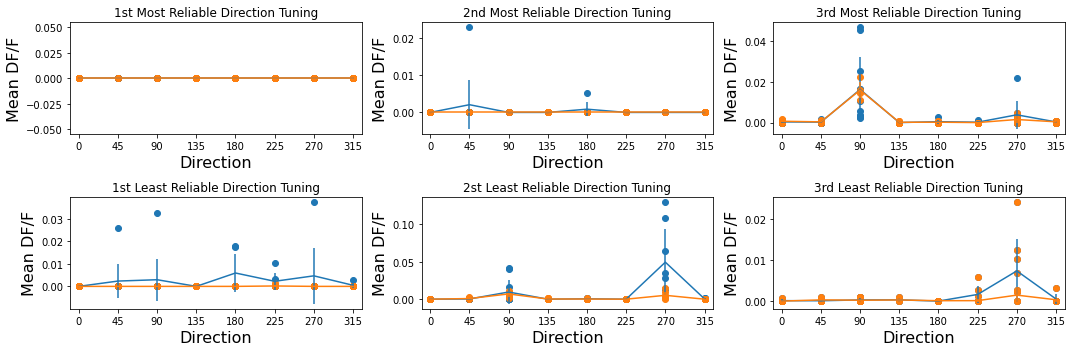

In [69]:
# sort models from worst to best performance on the test set
order = np.argsort(many_r2_test)

fig,ax = plt.subplots(ncols=3,nrows=  2,figsize=(15,5))
ax[0,0].errorbar(orientations, tuning_train[order[-1]],stdev_train[order[-1]],)
ax[0,0].scatter(orientation_a,mean_response_all_a[:,order[-1]])
ax[0,0].errorbar(orientations, tuning_test[order[-1]],stdev_test[order[-1]],)
ax[0,0].scatter(orientation_b,mean_response_all_b[:,order[-1]])
ax[0,0].set_title('1st Most Reliable Direction Tuning')

ax[0,1].errorbar(orientations, tuning_train[order[-2]],stdev_train[order[-2]],)
ax[0,1].scatter(orientation_a,mean_response_all_a[:,order[-2]])
ax[0,1].errorbar(orientations, tuning_test[order[-2]],stdev_test[order[-2]],)
ax[0,1].scatter(orientation_b,mean_response_all_b[:,order[-2]])
ax[0,1].set_title('2nd Most Reliable Direction Tuning')

ax[0,2].errorbar(orientations, tuning_train[order[-3]],stdev_train[order[-3]],)
ax[0,2].scatter(orientation_a,mean_response_all_a[:,order[-3]])
ax[0,2].errorbar(orientations, tuning_test[order[-3]],stdev_test[order[-3]],)
ax[0,2].scatter(orientation_b,mean_response_all_b[:,order[-3]])

ax[0,2].set_title('3rd Most Reliable Direction Tuning')


ax[1,0].errorbar(orientations, tuning_train[order[0]],stdev_train[order[0]],)
ax[1,0].scatter(orientation_a,mean_response_all_a[:,order[0]])
ax[1,0].errorbar(orientations, tuning_test[order[0]],stdev_test[order[0]],)
ax[1,0].scatter(orientation_b,mean_response_all_b[:,order[0]])
ax[1,0].set_title('1st Least Reliable Direction Tuning')


ax[1,1].errorbar(orientations, tuning_train[order[1]],stdev_train[order[1]],)
ax[1,1].scatter(orientation_a,mean_response_all_a[:,order[1]])
ax[1,1].errorbar(orientations, tuning_test[order[1]],stdev_test[order[1]],)
ax[1,1].scatter(orientation_b,mean_response_all_b[:,order[1]])
ax[1,1].set_title('2st Least Reliable Direction Tuning')

ax[1,2].errorbar(orientations, tuning_train[order[2]],stdev_train[order[2]],)
ax[1,2].scatter(orientation_a,mean_response_all_a[:,order[2]])

ax[1,2].errorbar(orientations, tuning_test[order[2]],stdev_test[order[2]],)
ax[1,2].scatter(orientation_a,mean_response_all_a[:,order[2]])

ax[1,2].set_title('3rd Least Reliable Direction Tuning')

for ii,x in enumerate(ax.flatten()):
    x.set_xticks(orientations)
    x.set_xlim(-10,325)
    x.set_xlabel("Direction", fontsize=16)
    x.set_ylabel("Mean DF/F", fontsize=16)
    


fig.set_tight_layout(True)


Its worth returning to the orientation selectivity statistic from before. By plotting the orientation selectivity against the reliability metric we just computed, we can see how the descriptive statistic maps onto cell reliability.

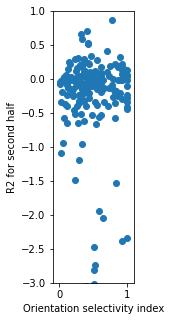

In [70]:
dsi = np.zeros(num_cells)
for ii,this_cell_id in enumerate(data_set.get_cell_specimen_ids()   ):
    dsi[ii] = cell_table[cell_table.cell_specimen_id==this_cell_id].g_dsi_dg.values[0]
fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(dsi,many_r2_test)

ax.set_xlabel('Orientation selectivity index')
ax.set_ylabel('R2 for second half')
ax.set_xlim(-.1,1.1) # The lower bound here is arbitrarty...
ax.set_ylim(-3,1)
ax.set_aspect('equal')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## 3.1 There is more than one way to split your data.
Up till now, all our analysis has focus on data that were split into the first and second halves of the behavior session. 

How, exactly, you split your data can have a profound impact on the question you are asking. Here,this means that our question wasn't just about the consistency of data- it was about stability of neural responses between the first and second half of the session. 

One valid alternative would have been to grab random halves. Another might have been to grab alternating trials under each experiment condition. All of these would have told us something about neural consistency, but each would have asked subtly different questions about our data and each would have made subtly different assumptions going in. There is no one answer for the 'best' way to split your data. Instead, you will always need to formulate a split to answer your question at hand.

## 3.1.1 You can use carful data splits to answer scientific questions.

So far, we have thought about variability as a problem. Now though, lets try a strategic split across experimental conditions to see if we can learn something.
    
In this case, we are going to how an animals running might impact the tuning of a cell.

### To Do:  a line to save the tuning.


We can get the running speed from the dataset information. 

Text(0, 0.5, 'speed (cm/s)')

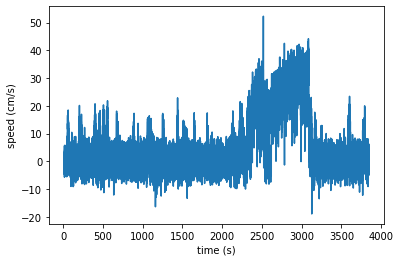

In [71]:
run_speed,run_ts = data_set.get_running_speed()
fig,ax = plt.subplots()
ax.plot(run_ts,run_speed)
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (cm/s)')   



Running has the same frame sampling as the stimulus table, so we can get the average running speed for each trial.

Text(0.5, 0, 'speed (cm/s)')

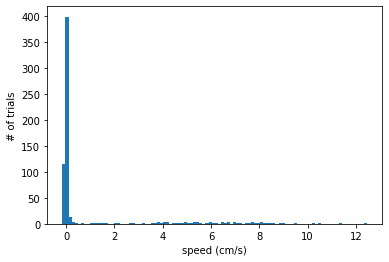

In [72]:
trial_running_speed = np.zeros(len(stim_table))
for ii,row in stim_table.iterrows():
    trial_running_speed[ii] = run_speed[int(row.start):int(row.end)].mean()
    
fig,ax = plt.subplots()
ax.hist(trial_running_speed,100)
ax.set_ylabel('# of trials')
ax.set_xlabel('speed (cm/s)')

Lets set a threshold on speed. Things above it will be "running" and below it will be "stopped."

In [73]:
threshold = .05
stopped = trial_running_speed<=threshold
running = trial_running_speed>threshold

We will need to recompute some of the variables above, since will filtered our data at some point in there.

In [74]:
orientation = np.zeros((len(stim_table)))
temp_freq = np.zeros((len(stim_table)))
response = np.zeros((len(stim_table),60))
mean_response_all = np.zeros((len(stim_table),num_cells))
for ii in range(len(stim_table)):
    orientation[ii] = stim_table.orientation[ii]
    temp_freq[ii] = stim_table.temporal_frequency[ii]
    for cc in range(num_cells):
        this_response =  events[cc,stim_table.start[ii]:stim_table.start[ii]+60]
        mean_response_all[ii,cc] = this_response.mean()

# Some stimuli don't have orientation, so we need to remove those trials
keep_me = ~np.isnan(orientation)
orientation = orientation[keep_me]
mean_response_all = mean_response_all[keep_me,:] 
running = running[keep_me] 
stopped = stopped[keep_me]
 
orientations,ix = np.unique(orientation,return_inverse=True)


Next, we are going to divide up our data. We have the obvious divide of "running" and "stopped" trials but - as we learned before - this isn't an entirely fair comparison. We need to also compare two halves of our "running" and "not running" data. 

In [75]:
running_trials = np.where(running)[0]
running_trials_1st_half = running_trials[:len(running_trials)//2]
running_trials_2st_half = running_trials[len(running_trials)//2:]

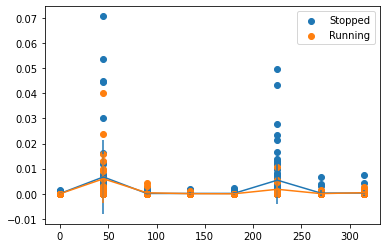

In [76]:
cell_idx = 171
tuning_running,stdev_running = compute_tuning_curve(mean_response_all[running,cell_idx],orientation[running],orientations) 
tuning_stopped,stdev_stopped = compute_tuning_curve(mean_response_all[stopped,cell_idx],orientation[stopped],orientations) 

fig,ax = plt.subplots()

ax.errorbar(orientations,tuning_stopped,stdev_stopped)
ax.scatter(orientation[stopped],mean_response_all[stopped,cell_idx],label = 'Stopped')
ax.errorbar(orientations,tuning_running,stdev_running)
ax.scatter(orientation[running],mean_response_all[running,cell_idx],label = 'Running')

ax.legend()




In [77]:
many_r2_running = np.zeros(num_cells)
many_r2_stopped = np.zeros(num_cells)

tuning_running = np.zeros((num_cells,orientations.shape[0]))
tuning_running_1 = np.zeros((num_cells,orientations.shape[0]))

for cc in range(num_cells):
    # Using running to predict stopped response
    tuning_running[cc,:],_ =compute_tuning_curve(mean_response_all[running_trials,cc],orientation[running_trials],orientations)
    prediction_stopped = tuning_running[cc,ix[stopped]]
    many_r2_stopped[cc] = compute_coefficient_of_determination(mean_response_all[stopped,cc],prediction_stopped)

    # Use half of running to predict other half.
    tuning_running_1[cc,:],s_ =compute_tuning_curve(mean_response_all[running_trials_1st_half,cc],orientation[running_trials_1st_half],orientations) 
    prediction_running = tuning_running_1[cc,ix[running_trials_2st_half]]
    many_r2_running[cc] = compute_coefficient_of_determination(mean_response_all[running_trials_2st_half,cc],prediction_running)




In [78]:
print('R^2 running-->running:' +str(many_r2_running[cell_idx]))
print('R^2 running-->stopped: ' + str(many_r2_stopped[cell_idx]))

R^2 running-->running:0.23896625079125478
R^2 running-->stopped: 0.10346499482994476


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


So what did this teach us? 

A model fit to "running" trials does better at predicting other "running" trials than "stopped" trials. In other words, we found a that changes tunning its tuning based on the mouse's behavior!
    
After lunch, we will learn to formalize some of this analysis, including tools for systematic data splitting and evaluation the inclusion and formulation of model parameters. For now, though, lets eat!
    
